- In this notebook, we analyze phage screens results starting from the counts table generated from the sequencing fastq files.
- All screens were performed in 3 replicates. For phage lambda, the library was sequenced before infection (Before_lambda_186_transduction samples 1-3), after 2 hours of infection at MOI = 1 (After_Lambda samples 1-3) and after the transduction assay (After_transduction samples 1-3). For phages 186 and T4, the library was also sequenced before and after 2 hours of infection at MOI = 1. For technical reasons, the samples before infection are common between phages lambda and 186 (Before_lambda_186_transduction samples 1-3) but distinct from samples before T4 infection (Before_T4 samples 1-3).

In [2]:
library(DESeq2)
library(ggplot2)
library(stringr)
library('pROC')
library(ROCR)
library(grid)
library(repr)
library(Rmisc)
library("ggrepel")
library(reshape2)

# DESeq2 and log2FoldChange computation

- From the counts table, we use DESeq2 to perform statistical analysis of enrichment/depletion of sgRNAs.

In [3]:
# We open the counts table and filter out guides with less than 20 reads in total.
counts = read.table('Counts_table_phages.txt')
counts=counts[rowSums(counts)>20,]

In [4]:
# We create a metadata table for DESeq2
samples = data.frame(label=colnames(counts))
samples$replicate = gsub(".*_","",samples$label)
samples$replicate=as.factor(samples$replicate)
samples$condition = gsub("_\\d$","",samples$label)
samples$condition=as.factor(samples$condition)
samples = samples[order(samples$replicate),]
samples = samples[order((samples$condition)),]
rownames(samples) = samples$label
samples

label                            replicate
After_186_1                      After_186_1                      1        
After_186_2                      After_186_2                      2        
After_186_3                      After_186_3                      3        
After_Lambda_1                   After_Lambda_1                   1        
After_Lambda_2                   After_Lambda_2                   2        
After_Lambda_3                   After_Lambda_3                   3        
After_T4_1                       After_T4_1                       1        
After_T4_2                       After_T4_2                       2        
After_T4_3                       After_T4_3                       3        
After_transduction_1             After_transduction_1             1        
After_transduction_2             After_transduction_2             2        
After_transduction_3             After_transduction_3             3        
Before_Lambda_186_transduction_1 Before_Lambda_186_transduction_1 1        
Before_Lambda_186_transduction_2 Before_Lambda_186_transduction_2 2        
Before_Lambda_186_transduction_3 Before_Lambda_186_transduction_3 3        
Before_T4_1                      Before_T4_1                      1        
Before_T4_2                      Before_T4_2                      2        
Before_T4_3                      Before_T4_3                      3        
                                 condition                     
After_186_1                      After_186                     
After_186_2                      After_186                     
After_186_3                      After_186                     
After_Lambda_1                   After_Lambda                  
After_Lambda_2                   After_Lambda                  
After_Lambda_3                   After_Lambda                  
After_T4_1                       After_T4                      
After_T4_2                       After_T4                      
After_T4_3                       After_T4                      
After_transduction_1             After_transduction            
After_transduction_2             After_transduction            
After_transduction_3             After_transduction            
Before_Lambda_186_transduction_1 Before_Lambda_186_transduction
Before_Lambda_186_transduction_2 Before_Lambda_186_transduction
Before_Lambda_186_transduction_3 Before_Lambda_186_transduction
Before_T4_1                      Before_T4                     
Before_T4_2                      Before_T4                     
Before_T4_3                      Before_T4

In [5]:
#For DESeq2, samples have to be in the same order between counts table and metadata table.
counts=counts[,samples$label]
head(counts)

After_186_1 After_186_2 After_186_3 After_Lambda_1
AAAAAAACTGCCCCGTGAAC 1           2           1           2             
AAAAAAAGATGATACGTCAG 1           1           2           3             
AAAAAAAGCCAGCACCCGGC 0           1           1           0             
AAAAAAAGCGATTTAACCGT 0           4           1           0             
AAAAAAATCCCGACCCTGAG 1           2           0           1             
AAAAAACAGCAGACGGTCTA 2           6           4           3             
                     After_Lambda_2 After_Lambda_3 After_T4_1 After_T4_2
AAAAAAACTGCCCCGTGAAC 1              2              7          2         
AAAAAAAGATGATACGTCAG 1              3              3          2         
AAAAAAAGCCAGCACCCGGC 1              0              3          1         
AAAAAAAGCGATTTAACCGT 2              1              8          0         
AAAAAAATCCCGACCCTGAG 0              1              2          2         
AAAAAACAGCAGACGGTCTA 1              1              7          3         
                     After_T4_3 After_transduction_1 After_transduction_2
AAAAAAACTGCCCCGTGAAC 3          2                    4                   
AAAAAAAGATGATACGTCAG 1          2                    4                   
AAAAAAAGCCAGCACCCGGC 0          0                    1                   
AAAAAAAGCGATTTAACCGT 2          1                    5                   
AAAAAAATCCCGACCCTGAG 3          0                    1                   
AAAAAACAGCAGACGGTCTA 7          1                    7                   
                     After_transduction_3 Before_Lambda_186_transduction_1
AAAAAAACTGCCCCGTGAAC 2                    2                               
AAAAAAAGATGATACGTCAG 5                    5                               
AAAAAAAGCCAGCACCCGGC 1                    2                               
AAAAAAAGCGATTTAACCGT 0                    3                               
AAAAAAATCCCGACCCTGAG 2                    2                               
AAAAAACAGCAGACGGTCTA 5                    4                               
                     Before_Lambda_186_transduction_2
AAAAAAACTGCCCCGTGAAC 2                               
AAAAAAAGATGATACGTCAG 2                               
AAAAAAAGCCAGCACCCGGC 0                               
AAAAAAAGCGATTTAACCGT 1                               
AAAAAAATCCCGACCCTGAG 2                               
AAAAAACAGCAGACGGTCTA 2                               
                     Before_Lambda_186_transduction_3 Before_T4_1 Before_T4_2
AAAAAAACTGCCCCGTGAAC 2                                5           3          
AAAAAAAGATGATACGTCAG 1                                4           2          
AAAAAAAGCCAGCACCCGGC 0                                5           5          
AAAAAAAGCGATTTAACCGT 1                                1           2          
AAAAAAATCCCGACCCTGAG 1                                3           0          
AAAAAACAGCAGACGGTCTA 0                                5           8          
                     Before_T4_3
AAAAAAACTGCCCCGTGAAC 9          
AAAAAAAGATGATACGTCAG 6          
AAAAAAAGCCAGCACCCGGC 2          
AAAAAAAGCGATTTAACCGT 4          
AAAAAAATCCCGACCCTGAG 6          
AAAAAACAGCAGACGGTCTA 7

- DESeq2 is run after normalizing reads to the control "TGAGACCAGTCTAGGTCTCG" (no target in the genome).
- Paired analysis is performed between biological replicates.

In [6]:
dds <- DESeqDataSetFromMatrix(countData=counts, colData=samples, design = ~ condition + replicate)
targetControl <- as.numeric(counts(dds)["TGAGACCAGTCTAGGTCTCG",])
sizeFactors(dds) <- targetControl/mean(targetControl)
dds <- estimateDispersions(dds)
dds <- nbinomWaldTest(dds, betaPrior=FALSE)

#guides_info table contains guide information (position, target gene, etc...)
guides_info=read.table('library.txt',header=T)
guides_info = guides_info[!is.na(guides_info$target),]
#Filtered_library.txt contains the library where guides having a 11-nt match on the coding strand of a gene or a 9-nt in a promoter have been removed.
targets=read.table('Filtered_library.txt')$V1
#We keep only guides without potential off-target activity and without bad-seed effect.
guides_info=guides_info[guides_info$target %in% targets,]
guides_info=guides_info[!(substr(as.character(guides_info$target),16,20) %in% c('AGGAA','ACCCA','TATAG','GAGGC','CACTC','AGGGG','AAAGG','AGGAG','TAGAC','CGGAA')),]


lambda <- results(dds,contrast=c('condition','After_Lambda','Before_Lambda_186_transduction'))
lambda$target=rownames(lambda)
lambda=merge(guides_info[,c("target","pos","gene","essential","ori","gene_ori","coding","gene_right","gene_left","ntargets"),],as.data.frame(lambda[,c('target','baseMean','log2FoldChange','padj')]),by='target')
lambda=lambda[order(-lambda$log2FoldChange),]
lambda=lambda[lambda$baseMean>10 & !is.na(lambda$coding) & lambda$coding,]


P186 <- results(dds,contrast=c('condition','After_186','Before_Lambda_186_transduction'))
P186$target=rownames(P186)
P186=merge(guides_info[,c("target","pos","gene","essential","ori","gene_ori","coding","gene_right","gene_left","ntargets"),],as.data.frame(P186[,c('target','baseMean','log2FoldChange','padj')]),by='target')
P186=P186[order(-P186$log2FoldChange),]
P186=P186[P186$baseMean>10 & !is.na(P186$coding) & P186$coding,]

T4 <- results(dds,contrast=c('condition','After_T4','Before_T4'))
T4$target=rownames(T4)
T4=merge(guides_info[,c("target","pos","gene","essential","ori","gene_ori","coding","gene_right","gene_left","ntargets"),],as.data.frame(T4[,c('target','baseMean','log2FoldChange','padj')]),by='target')
T4=T4[order(-T4$log2FoldChange),]
T4=T4[T4$baseMean>10 & !is.na(T4$coding) & T4$coding,]


transduction <- results(dds,contrast=c('condition','After_transduction','Before_Lambda_186_transduction'))
transduction$target=rownames(transduction)
transduction=merge(guides_info[,c("target","pos","gene","essential","ori","gene_ori","coding","gene_right","gene_left","ntargets"),],as.data.frame(transduction[,c('target','baseMean','log2FoldChange','padj')]),by='target')
transduction=transduction[order(transduction$log2FoldChange),]
transduction=transduction[transduction$baseMean>10 & !is.na(transduction$coding) & transduction$coding,]

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


- We obtain 4 tables (lambda, T4 and 186 infection and transduction) containing log2FoldChange values. These table are filtered for off-target activity, bad-seed effect and low number of reads. In addition, we only kept guides targeting the coding strand of genes for the following analyses. 
- S3 Table is generated by merging the 3 infection tables into one.
- S4 Table is generated with the transduction data.

In [8]:
merged=merge(lambda[,c('target','log2FoldChange')],merge(T4[,c('target','log2FoldChange')],P186[,c('target','log2FoldChange','pos','ori','essential','gene','gene_left','gene_right','gene_ori')],by='target'),by="target")
colnames(merged)[c(2,3,4,5)]=c('log2FC_lambda','log2FC_T4','log2FC_186','position')
merged=merged[,c(1,5,6,8,7,9,10,11,2,3,4)]
head(merged)


target               position ori gene essential gene_left gene_right
1 AAAAAATGATGACGCAACGT  143931  -   yadH FALSE      143702    144472   
2 AAAAACCCGCCCTGTGCTTC 3295532  +   yraQ FALSE     3295120   3296160   
3 AAAAAGCTGCTGTTCGCTCT 1605998  -   tam  FALSE     1605370   1606128   
4 AAAAATCAGCATACCGGCGC 4560345  +   yjiJ FALSE     4559520   4560698   
5 AAAAATCATCTTGCACCTCC 1758560  +   sufD FALSE     1758544   1759815   
6 AAAAATCGCCATGCTCTGAC 4339385  +   melR FALSE     4338743   4339651   
  gene_ori log2FC_lambda log2FC_T4  log2FC_186
1 +         0.386708533  -0.9997311  0.2406165
2 -         0.424333173  -1.1795956  0.6817472
3 +        -0.006817146  -1.2131041  0.2729827
4 -         0.843709370  -0.9289631  0.8090655
5 -         1.072543827  -0.5827538 -0.3600747
6 -         0.524800975  -0.9162284 -0.0352420

# Comparison of phage resistance profiles

- We can draw volcano plots for each phage and highlight known receptors or waa genes for phage 186.

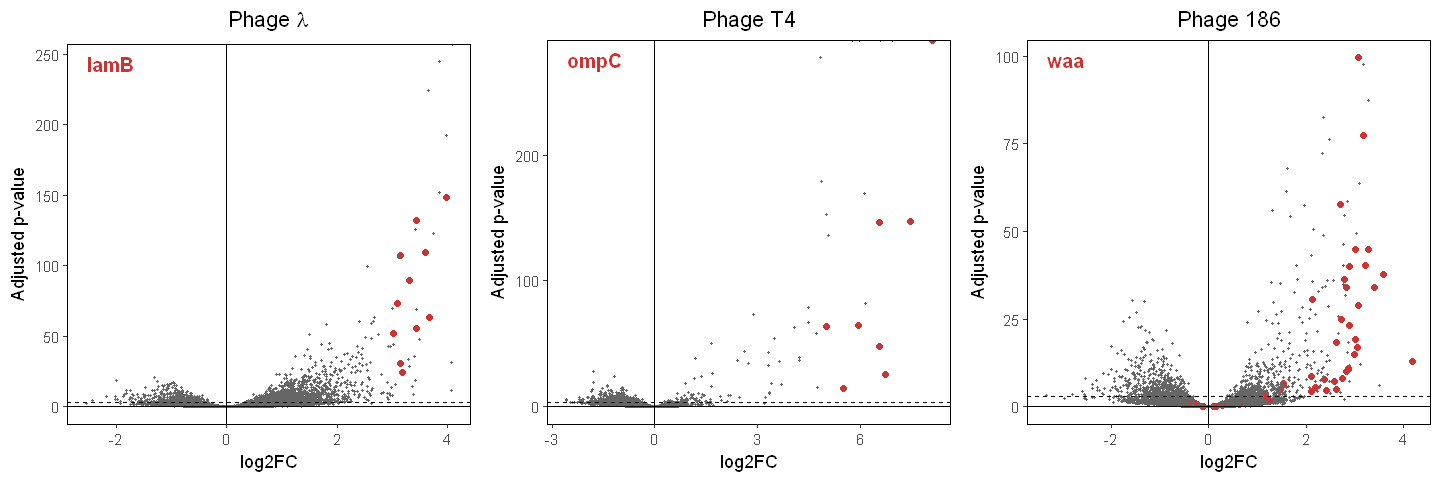

In [9]:
library(grid)
volcano_plot<-function(rdata,receptor){
  rdata$GENE=''
  rdata[grepl(receptor,rdata$gene),]$GENE=receptor
  ggplot(rdata,aes(log2FoldChange,-log10(padj),colour=GENE,size=factor(grepl(receptor,rdata$gene)),label=gene))+
    geom_point()+
    geom_hline(yintercept = -log10(0.001),linetype='dashed')+
    geom_vline(xintercept = 0)+
    geom_hline(yintercept = 0)+
    scale_color_manual(values=c('#666666','#CC3333'))+
    scale_size_manual(values=c(0.5,1.5))+
    xlab('log2FC')+
    ylab('Adjusted p-value')+
    annotation_custom(grobTree(textGrob(receptor, x=0.05,  y=0.95, hjust=0,gp=gpar(col="#CC3333", fontsize=12,fontface = 'bold'))))+
    theme(legend.position="none",panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.border = element_rect(colour = "black", fill=NA, size=0.5),panel.background = element_blank(),plot.title = element_text(hjust = 0.5))
}
options(repr.plot.width=12, repr.plot.height=4)
multiplot(volcano_plot(lambda,'lamB')+ggtitle(expression(paste("Phage ",lambda))),volcano_plot(T4,'ompC')+ggtitle("Phage T4"),volcano_plot(P186,'waa')+ggtitle("Phage 186"),layout=matrix(c(1,2,3), nrow=1, byrow=TRUE))

- The gene Resistance Scores for each phage are then calculated from the median log2FC of the guides targeting the coding strand.

In [7]:
operons=read.table('operon-table-regulonDB.txt')

medians_infection<-function(rdata){
  medians=unique(rdata[!is.na(rdata$gene),c('gene','essential','gene_ori','gene_left','gene_right')])
  medians$median_coding=1
  medians$mad_coding=1
  medians$coding=0
  medians$operon=0
  for (i in 1:dim(medians)[1]){
    if (length(operons[grepl(as.character(medians$gene[i]),operons$genes),]$name)==1){
      medians$operon[i]=as.character(operons[grepl(medians$gene[i],operons$genes),]$name)
    }else{
      medians$operon[i]=as.character(medians$gene[i])
    }
  }
  for (i in 1:dim(medians)[1]){
    medians$median_coding[i]=median(rdata[!is.na(rdata$log2FoldChange) &!is.na(rdata$essential) & rdata$gene==medians$gene[i] & rdata$coding,]$log2FoldChange)
    medians$mad_coding[i]=mad(rdata[!is.na(rdata$log2FoldChange) &!is.na(rdata$essential) & rdata$gene==medians$gene[i] &  rdata$coding,]$log2FoldChange)
    medians$coding[i]=dim(rdata[!is.na(rdata$log2FoldChange) &!is.na(rdata$essential) & rdata$gene==medians$gene[i] & rdata$coding,])[1]
  }
  medians=medians[order(-medians$median_coding),]
  medians$rank=1:dim(medians)[1]
  return(medians)
}

medians_lambda=medians_infection(lambda)
medians_T4=medians_infection(T4)
medians_P186=medians_infection(P186)

merged_medians=merge(medians_lambda[,c('gene','median_coding','mad_coding')],merge(medians_T4[,c('gene','median_coding','mad_coding')],medians_P186[,c('gene','median_coding','mad_coding','essential','coding','operon')],by='gene'),by="gene")
colnames(merged_medians)[c(2,3,4,5,6,7,8)]=c('Resistance_Score_lambda','mad_lambda','Resistance_Score_T4','mad_T4','Resistance_Score_186','mad_186','sgRNAs')
#merged_medians=merged_medians[,c(1,5,7,6,2,3,4)]
head(merged_medians)

gene essential operon     sgRNAs Resistance_Score_lambda Resistance_Score_T4
1 aaeA FALSE     aaeXAB      2     0.9726048               -1.0576161         
2 aaeB FALSE     aaeXAB      7     0.3784575               -0.2018990         
3 aaeR FALSE     aaeR        5     0.3248244               -0.3801992         
4 aas  FALSE     aas-lplT   20     0.1580913               -0.4742663         
5 aat  FALSE     aat         3     0.7340018                0.2322557         
6 abgA FALSE     abgABT-ogt  5     0.2048984               -0.4959963         
  Resistance_Score_186
1  0.89555761         
2 -0.09992377         
3  0.18551005         
4 -0.30679832         
5 -0.27478204         
6 -0.07503343

In [12]:
merged_medians=merge(medians_lambda[,c('gene','median_coding','mad_coding')],merge(medians_T4[,c('gene','median_coding','mad_coding')],medians_P186[,c('gene','median_coding','mad_coding','essential','coding','operon')],by='gene'),by="gene")
colnames(merged_medians)[c(2,3,4,5,6,7,9)]=c('Resistance_Score_lambda','mad_lambda','Resistance_Score_T4','mad_T4','Resistance_Score_186','mad_186','sgRNAs')
merged_medians=merged_medians[,c(1,8,2,3,4,5,6,7,9,10)]
head(merged_medians)

gene essential Resistance_Score_lambda mad_lambda Resistance_Score_T4
1 aaeA FALSE     0.9726048               0.9981883  -1.0576161         
2 aaeB FALSE     0.3784575               0.5830181  -0.2018990         
3 aaeR FALSE     0.3248244               0.4056049  -0.3801992         
4 aas  FALSE     0.1580913               0.5572401  -0.4742663         
5 aat  FALSE     0.7340018               0.8837844   0.2322557         
6 abgA FALSE     0.2048984               0.6582681  -0.4959963         
  mad_T4    Resistance_Score_186 mad_186   sgRNAs operon    
1 0.9013313  0.89555761          1.0380753  2     aaeXAB    
2 0.4217032 -0.09992377          0.4447203  7     aaeXAB    
3 0.1995601  0.18551005          0.3878884  5     aaeR      
4 0.3178811 -0.30679832          0.5225201 20     aas-lplT  
5 0.5240247 -0.27478204          0.3604603  3     aat       
6 0.1623977 -0.07503343          0.2665450  5     abgABT-ogt

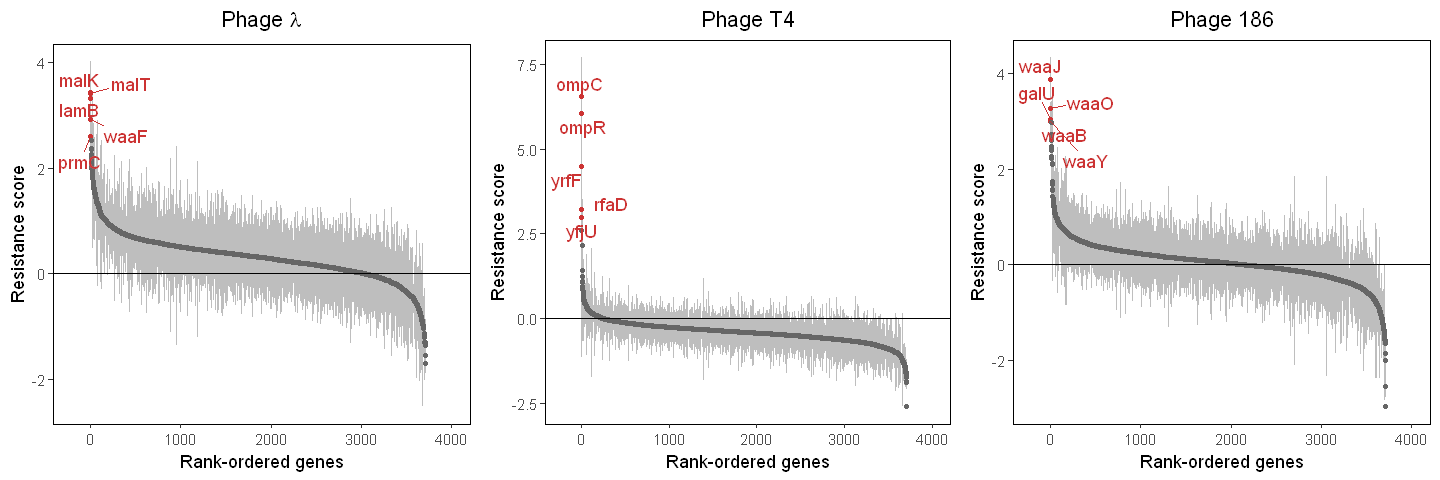

In [13]:
rank_plot<-function(medians){
  ggplot(medians,aes(rank,median_coding,label=gene,colour=factor(rank<6)))+
    geom_errorbar(aes(ymin=median_coding-mad_coding,ymax=median_coding+mad_coding),colour='grey',width=0.001,size=0.1)+
    geom_point(size=1)+
    geom_text_repel(data=subset(medians,rank<6))+
    scale_color_manual(values=c('#666666','#CC3333'))+
    geom_hline(yintercept = 0)+
    xlim(c(-200,4000))+
    xlab('Rank-ordered genes')+
    ylab('Resistance score')+
    theme(legend.position="none",panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.border = element_rect(colour = "black", fill=NA, size=0.5),panel.background = element_blank(),plot.title = element_text(hjust = 0.5))
  }

options(repr.plot.width=12, repr.plot.height=4)
multiplot(rank_plot(medians_lambda)+ggtitle(expression(paste("Phage ",lambda))),rank_plot(medians_T4)+ggtitle("Phage T4"),rank_plot(medians_P186)+ggtitle("Phage 186"),layout=matrix(c(1,2,3), nrow=1, byrow=TRUE))


- We can compare the Resistance score values between phages by calculating the correlation coefficients of resistance scores of all genes between two phages.

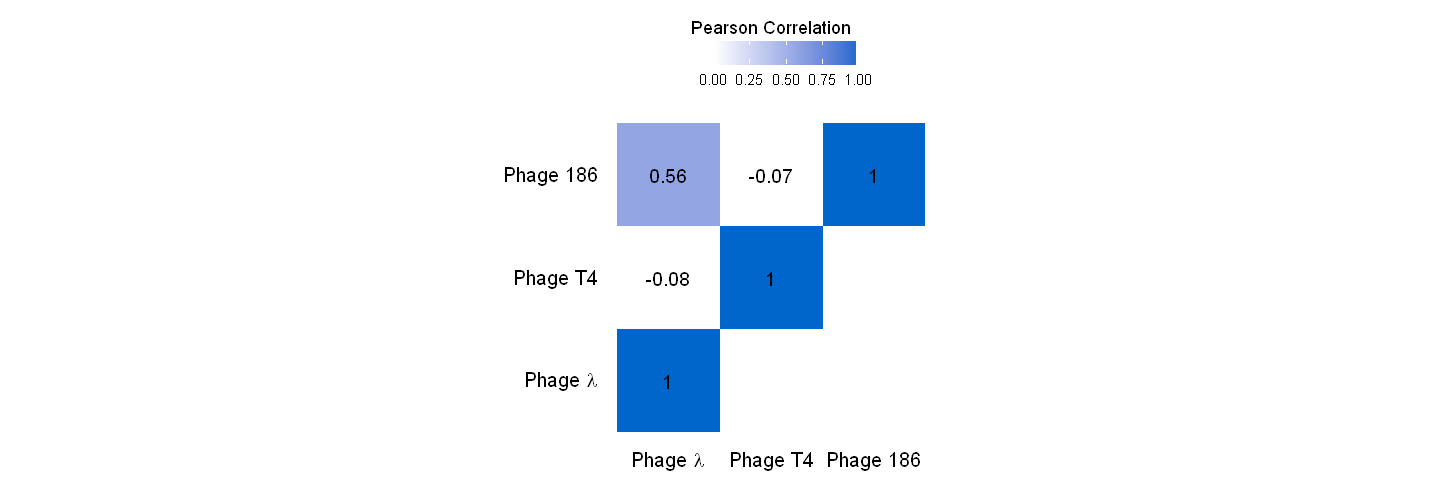

In [14]:
normalized_medians=merged_medians[,c(1,4,5,6,7)]
colnames(normalized_medians)=c('gene','sgRNAs','lambda','T4','P186')
normalized_medians$lambda=normalized_medians$lambda/max(normalized_medians$lambda)
normalized_medians$T4=normalized_medians$T4/max(normalized_medians$T4)
normalized_medians$P186=normalized_medians$P186/max(normalized_medians$P186)
rownames(normalized_medians)=normalized_medians$gene
normalized_medians$gene=NULL


correlations=cor(normalized_medians)
dd <- as.dist((1-correlations)/2)
hc <- hclust(dd)
correlations[upper.tri(correlations)]=NA
l=melt(correlations,na.rm = TRUE)


p=ggplot(data = l, aes(Var2, Var1, fill = value))+
  geom_tile()+
  scale_fill_gradient2(low = "white", high = "#0066CC", limit = c(-0.2,1), space = "Lab",name="Pearson Correlation") +
  coord_fixed()+
  geom_text(aes(Var2, Var1, label = round(value,2)), color = "black", size = 4)+
  scale_x_discrete(limit = c("lambda","T4", "P186"),labels=c(expression(paste("Phage ",lambda)),'Phage T4','Phage 186'))+
  scale_y_discrete(limit = c("lambda","T4", "P186"),labels=c(expression(paste("Phage ",lambda)),'Phage T4','Phage 186'))+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1, colour='black', title.position = "top", title.hjust = 0.5))+
  theme(legend.position = 'top',legend.direction = "horizontal",axis.text = element_text(color = "black", size = 12), axis.title.x = element_blank(), axis.ticks.x=element_blank(),axis.title.y = element_blank(),axis.ticks.y=element_blank(),panel.grid.major = element_blank(),panel.background = element_blank())
print(p)

- For each phage, Resistance Scores are then normalized by the maximum resistance scores. This allows to select genes which silencing improves survival above a certain threshold. Here, we chose 0.2 (20% of the maximum score) as a threshold.

(polygon[GRID.polygon.408], polygon[GRID.polygon.409], polygon[GRID.polygon.410], polygon[GRID.polygon.411], polygon[GRID.polygon.412], polygon[GRID.polygon.413], text[GRID.text.414], text[GRID.text.415], text[GRID.text.416], text[GRID.text.417], text[GRID.text.418], text[GRID.text.419], text[GRID.text.420], text[GRID.text.421], text[GRID.text.422], text[GRID.text.423]) 

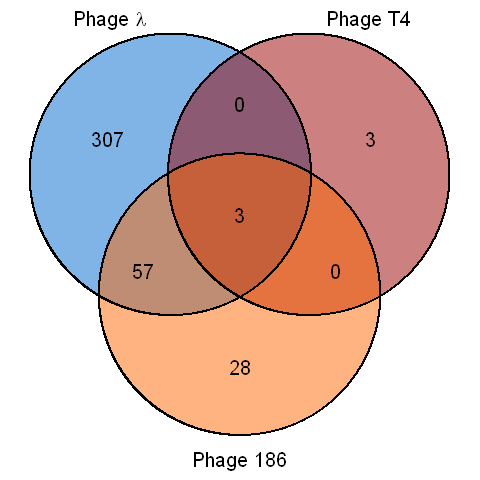

In [17]:
normalized_medians=normalized_medians[normalized_medians$sgRNAs>1,]
normalized_medians$gene=rownames(normalized_medians)
threshold=0.2
mL=normalized_medians[normalized_medians$lambda>threshold,]
mT4=normalized_medians[normalized_medians$T4>threshold,]
m186=normalized_medians[normalized_medians$P186>threshold,]

options(repr.plot.width=4, repr.plot.height=4)
library(VennDiagram)

p=draw.triple.venn(area1 = dim(mL)[1], area2=dim(mT4)[1],area3=dim(m186)[1],
                 n12 = dim(normalized_medians[normalized_medians$lambda>threshold & normalized_medians$T4>threshold,])[1],
                 n23 = dim(normalized_medians[normalized_medians$T4>threshold & normalized_medians$P186>threshold,])[1],
                 n13 = dim(normalized_medians[normalized_medians$lambda>threshold  & normalized_medians$P186>threshold,])[1],
                 n123 = dim(normalized_medians[normalized_medians$lambda>threshold & normalized_medians$T4>threshold & normalized_medians$P186>threshold,])[1],
                 category = c(expression(paste("Phage ",lambda)),'Phage T4','Phage 186'),fill = c("#0066CC", "#990000", "#FF6600"),
                cex=1, fontfamily="sans",lwd = rep(2, 3), lty =rep("solid", 3), col = rep("black", 3),
                cat.cex = 1,cat.pos = c(-20,20,180),cat.fontfamily = "sans",cat.dist = c(0.05, 0.05,0.05)
                )
print(p)

- The three common genes can be visualized:

In [18]:
normalized_medians[normalized_medians$lambda>threshold & normalized_medians$T4>threshold & normalized_medians$P186>threshold,]

sgRNAs lambda    T4        P186      gene
rfaD  7     0.6927257 0.4911887 0.5826674 rfaD
waaF  4     0.8495610 0.2172130 0.6692889 waaF
yrfF 12     0.3011124 0.6840848 0.2136410 yrfF

# Transduction assay

- The screen performed here is thus a powerful method to identify genes required by phages to kill the cell. However, this first strategy cannot identify genes necessary for the synthesis of functional phage capsids if blocking the expression of these genes does not prevent the phage from killing the bacteria. One can expect that this will be the case of any host gene involved in late stages of the infectious cycle when the host cell is already doomed. In order to get better insights into the genes affecting the production of functional phages, we implemented a second step focusing on phage λ.
- After infection by phage λ, the cell lysate containing a mixture of λ and cosmid particles was used to transduce strain MG1655::λ and thus recover guides in the library that do not affect the infection process. The distribution of sgRNAs recovered after transduction was compared to the initial pool to identify depleted sgRNAs corresponding to bacterial genes required for the production of functional capsids.
- When comparing our data with the essentiality data from our previous screen, we observed a strong correlation between the effect of guides on the cell fitness (log2FC_fitness) and log2FC after transduction (log2FC_transduction).

In [20]:
rdata=read.table('Essentiality_screen_data.txt',header=T)
transduction_data=merge(transduction[,c('target','gene','essential','log2FoldChange')],rdata[,c('target','log2FoldChange')],by='target')
colnames(transduction_data)=c('target','gene','essential','log2FC_transduction','log2FC_fitness')

lm=summary(lm(transduction_data$log2FC_transduction~transduction_data$log2FC_fitness))
print(lm)


Call:
lm(formula = transduction_data$log2FC_transduction ~ transduction_data$log2FC_fitness)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8650 -0.3772  0.1544  0.5515  5.7886 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -0.557564   0.008507  -65.55   <2e-16 ***
transduction_data$log2FC_fitness  0.778702   0.004706  165.49   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9827 on 17214 degrees of freedom
Multiple R-squared:  0.614,	Adjusted R-squared:  0.614 
F-statistic: 2.739e+04 on 1 and 17214 DF,  p-value: < 2.2e-16



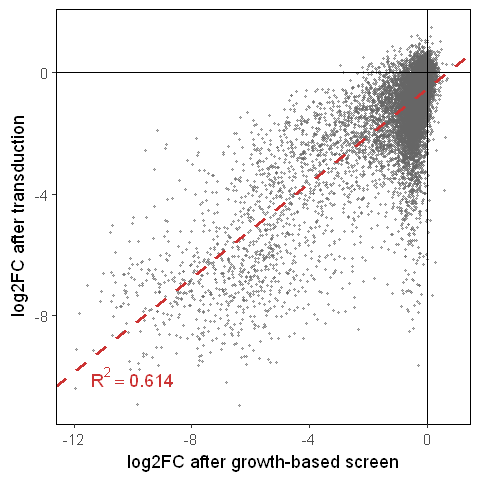

In [21]:
options(repr.plot.width=4, repr.plot.height=4)
p=ggplot(transduction_data,aes(log2FC_fitness,log2FC_transduction))+
  geom_point(size=0.5,colour='#666666',alpha=0.5)+
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(intercept = lm$coefficients[1,1],slope=lm$coefficients[2,1],linetype='dashed',colour='#CC3333',size=1)+
  annotate('text',x=-10,y=-10,label=paste("R^2 == ", round(lm$r.squared,4)),parse=TRUE,colour='#CC3333')+
  theme(legend.position="none",panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.border = element_rect(colour = "black", fill=NA, size=0.5),panel.background = element_blank(),plot.title = element_text(hjust = 0.5))+
  xlab('log2FC after growth-based screen')+
  ylab('log2FC after transduction')
print(p)

- In order to identify genes which disproportionately affect phage production over cell growth, we performed statistical analyses taking the effect on growth into account. 
- A linear model was built to predict log2FC after transduction (log2FC_transduction) as a function of the log2FC values obtained from the growth-based screen (log2FC_fitness) and a Boolean parameter considering the gene, or not, as a host factor. A given gene was regarded as a hit when the Boolean parameter significantly improved the model after correction for multiple testing (FDR < 0.05), while the regression coefficient of this parameter termed as “estimate” was used for gene ranking. Genes whose silencing decreases the production of functional capsids have a negative estimate after transduction. 

In [22]:
gene_ranking=unique(transduction_data[,c("essential","gene")])
gene_ranking=gene_ranking[!is.na(gene_ranking$gene),]
gene_ranking=gene_ranking[order(gene_ranking$gene),]
gene_ranking$nb_guides=0
gene_ranking$pvalue=1
gene_ranking$estimate=0
gene_ranking$sd=0

for (i in 1:dim(gene_ranking)[1]){
  if (length(operons[grepl(as.character(gene_ranking$gene[i]),operons$genes),]$name)==1){
      gene_ranking$operon[i]=as.character(operons[grepl(gene_ranking$gene[i],operons$genes),]$name)
  }else{
      gene_ranking$operon[i]=as.character(gene_ranking$gene[i])
    }  
    
    
  gene_ranking$nb_guides[i]=dim(transduction_data[transduction_data$gene==gene_ranking$gene[i] & !is.na(transduction_data$gene),])[1]
  transduction_data$hostfactor=0
  transduction_data[transduction_data$gene==gene_ranking$gene[i] & !is.na(transduction_data$gene),]$hostfactor=1
  l=summary(lm(transduction_data$log2FC_transduction~transduction_data$log2FC_fitness+transduction_data$hostfactor))
  gene_ranking$pvalue[i]=l$coefficients[3,4]
  gene_ranking$estimate[i]=l$coefficients[3,1]
  gene_ranking$sd[i]=l$coefficients[3,2]
}
gene_ranking$FDR=p.adjust(gene_ranking$pvalue,method='fdr')
gene_ranking=gene_ranking[order(gene_ranking$pvalue),]
gene_ranking=gene_ranking[,c(2,1,7,3,5,4,8)]

- The top-scoring genes can be visualized in a table and in a volcano plot:

In [23]:
head(gene_ranking[gene_ranking$estimate<0,],10)

gene essential operon              nb_guides estimate  pvalue      
1163  malT FALSE     malT                13        -5.506318 9.507092e-92
1954  groL  TRUE     groSL               12        -3.539736 7.959986e-36
407   lamB FALSE     malK-lamB-malM      11        -3.642292 7.550536e-35
10192 rho   TRUE     rhoL-rho             6        -4.703108 7.617271e-32
1307  malK FALSE     malK-lamB-malM       7        -4.191946 1.255444e-29
1654  dnaJ FALSE     dnaK-tpke11-dnaJ     8        -3.453088 2.520229e-23
380   rpoB  TRUE     rplKAJL-rpoBC       18        -2.276120 1.037828e-22
2712  rpoD  TRUE     rpsU-dnaG-rpoD       8        -3.180121 5.637709e-20
389   rpoH FALSE     rpoH                 7        -3.062618 1.563787e-16
115   spoT  TRUE     rpoZ-spoT-trmH-recG 13        -2.113844 9.037095e-15
      FDR         
1163  3.525230e-88
1954  1.475781e-32
407   9.332462e-32
10192 7.061210e-29
1307  7.758643e-27
1654  1.335001e-20
380   4.810334e-20
2712  2.322736e-17
389   5.798524e-14
115   2.792462e-12

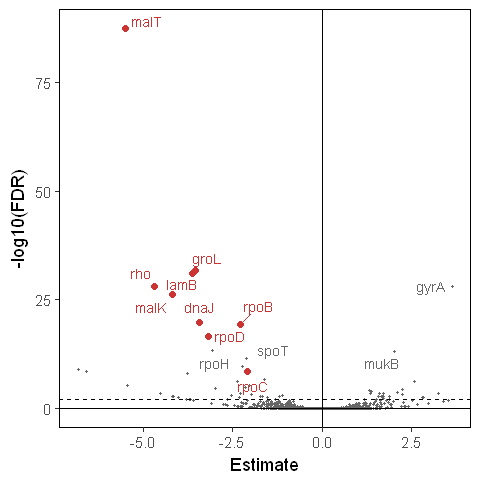

In [24]:
known_hostfactors=c('lamB','malT','malK','groL','rho','dnaJ','rpoB','rpoC','rpoD')

options(repr.plot.width=4, repr.plot.height=4)
p=ggplot(gene_ranking,aes(estimate,-log10(FDR),colour=factor(gene %in% known_hostfactors),size=factor(gene %in% known_hostfactors),label=gene))+
  geom_point()+
  geom_hline(yintercept = -log10(0.01),linetype='dashed')+
  geom_vline(xintercept = 0)+
  geom_hline(yintercept = 0)+
  scale_color_manual(values=c('#666666','#CC3333'))+
  scale_size_manual(values=c(0.5,1.5))+
  xlab('Estimate')+
  geom_text_repel(data=subset(gene_ranking, FDR<10**(-10) | gene %in% known_hostfactors ),size=3)+
  theme(legend.position="none",panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.border = element_rect(colour = "black", fill=NA, size=0.5),panel.background = element_blank(),plot.title = element_text(hjust = 0.5))
print(p)

When comparing transduction results with the infection results, we can classify the 57 selected genes in two groups: 
  - genes with a positive resistance score provide resistance to lysis when silenced
  - genes with a negative resistance score lead to an increased sensitivity to the phage but a reduced production of functional phage particles.

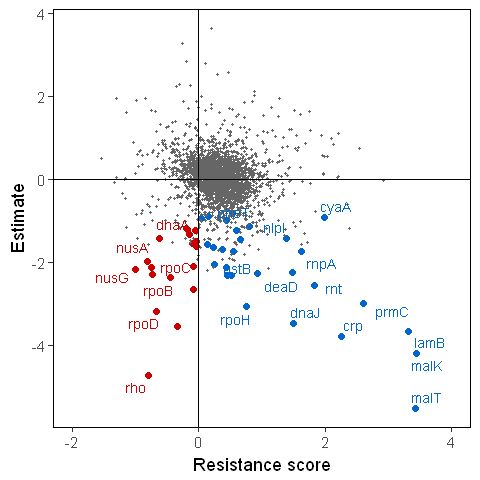

In [28]:
comparison=merge(medians_lambda[medians_lambda$coding>1,c('gene','median_coding')],gene_ranking[,c('essential','gene','nb_guides','FDR','estimate')],by='gene')
comparison=comparison[order(-comparison$median_coding),]
comparison$plot=0
comparison[comparison$median_coding<0 & comparison$estimate<0 & comparison$FDR<0.05,]$plot=1
comparison[comparison$median_coding>0 & comparison$estimate<0 & comparison$FDR<0.05,]$plot=2

options(repr.plot.width=4, repr.plot.height=4)
p=ggplot(comparison,aes(median_coding,estimate,label=gene,size=factor(plot>0),colour=factor(plot)))+
  geom_point()+
  geom_vline(xintercept = 0)+
  geom_hline(yintercept = 0)+
  scale_size_manual(values=c(0.5,1.5))+
  xlab('Resistance score')+
  ylab('Estimate')+
  xlim(c(-2,4))+
  scale_colour_manual(values=c('#666666','#CC0000','#0066CC'))+
  geom_text_repel(data=subset(comparison[comparison$plot>0,],median_coding<(-0.5) | median_coding>0.7),size=3)+
  theme(legend.position="none",panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.border = element_rect(colour = "black", fill=NA, size=0.5),panel.background = element_blank(),plot.title = element_text(hjust = 0.5))
print(p)